In [1]:
using SparseArrays, LinearAlgebra, IndexedGraphs
using Causality
using Plots
using JLD2

# Generation of Epidemics

In [65]:
T = 20 
N = 904
out = load("./SimulatedGraphs/Tubingen_seed1.jld2")
V = [MaskedRate(UnitRate(),v) for v in  out["V"]]
G = out["G"];

In [66]:
getpar(pseed,autoinf::GaussianRate,inf_in::GaussianRate) = 
    [fill(pseed, 1, N);
     fill(autoinf.a, 1, N); fill(autoinf.b, 1, N); fill(autoinf.c, 1, N);
     fill(inf_in.a,   1, N); fill(inf_in.b, 1, N); fill(inf_in.c, 1, N);
    ]

getpargen(pseed, autoinf::GaussianRate, inf_out::GaussianRate) = 
    [pseed autoinf.a autoinf.b autoinf.c inf_out.a inf_out.b inf_out.c]


getpargen (generic function with 1 method)

In [67]:
#Initialize generation parameters
T = 20 * 24
ε = 1e-10
λ = 0.15
pseed = 5/N
autoinf = GaussianRate(ε, T/2, 1/ε)
inf_in = GaussianRate(1.0, T/2, 1/ε)
inf_out = GaussianRate(λ, T/2, 1/ε)

θp = getpar(pseed, autoinf, inf_in);
θpgen = getpargen(pseed, autoinf, inf_out);

In [68]:
#Initialize min/max boundaies
T = Float64(T)
pseed_min = ε
pseed_max = 1-ε
rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  2T,   1/ε)

inf_min = GaussianRate(ε  ,  -T,   ε)
inf_max = GaussianRate(1/ε  ,  2T, 1. )

θmin = getpar(pseed_min , rate_min, rate_min);
θmax = getpar(pseed_max , rate_max, rate_max);

rate_min = GaussianRate(ε  ,  -T,   ε)
rate_max = GaussianRate(1/ε  ,  T,   T)

θgenmin = getpargen(pseed_min, rate_min, rate_min);
θgenmax = getpargen(pseed_max, rate_max, rate_max);

In [69]:
const Igen = GenerativeSI{GaussianRate,GaussianRate} 
const Igauss = GaussianInferentialSI

GaussianInferentialSI

0.5508849557522124


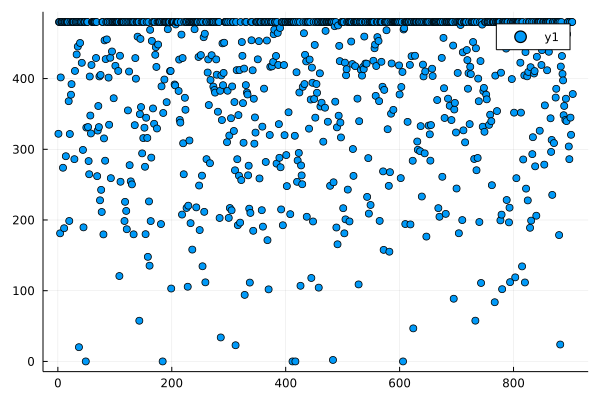

In [82]:


Mp = StochasticModel(Igen, T, θp, G, θpgen, V);
sample! = Sampler(Mp);
xtrue = zeros(N)
ni = 0

sample!(xtrue)
println(sum(xtrue .< T)/N)
scatter(xtrue)


In [83]:
nobs, p = 100, 1e-5 #p is mute
O = [(ti = T; (i,xtrue[i] < ti, ti,p)) for i=1:nobs]

100-element Vector{Tuple{Int64, Bool, Int64, Float64}}:
 (1, 1, 480, 1.0e-5)
 (2, 0, 480, 1.0e-5)
 (3, 0, 480, 1.0e-5)
 (4, 1, 480, 1.0e-5)
 (5, 1, 480, 1.0e-5)
 (6, 0, 480, 1.0e-5)
 (7, 0, 480, 1.0e-5)
 (8, 0, 480, 1.0e-5)
 (9, 1, 480, 1.0e-5)
 (10, 0, 480, 1.0e-5)
 (11, 1, 480, 1.0e-5)
 (12, 0, 480, 1.0e-5)
 (13, 0, 480, 1.0e-5)
 ⋮
 (89, 1, 480, 1.0e-5)
 (90, 1, 480, 1.0e-5)
 (91, 0, 480, 1.0e-5)
 (92, 1, 480, 1.0e-5)
 (93, 1, 480, 1.0e-5)
 (94, 0, 480, 1.0e-5)
 (95, 1, 480, 1.0e-5)
 (96, 0, 480, 1.0e-5)
 (97, 0, 480, 1.0e-5)
 (98, 1, 480, 1.0e-5)
 (99, 0, 480, 1.0e-5)
 (100, 0, 480, 1.0e-5)

## Causality 

In [84]:
#Softened model
T = Float64(T)
ε = 2e-3/24
autoinf = GaussianRate(ε, T/2, T);
θp2gen = getpargen(pseed, autoinf, inf_out);
inf_in = GaussianRate(1., T/2, 3*T );

θp2 = getpar(pseed, autoinf, inf_in);
Mp2 = StochasticModel(Igen, T, θp2, G, θp2gen, V);

In [85]:
θ = getpar(pseed, autoinf, inf_in);
autoinf = GaussianRate(1., T/2, T);
M = StochasticModel(Igauss, T, θ, G, θp2gen, V);

In [ ]:
using ProgressMeter
ProgressMeter.ijulia_behavior(:clear)
F = descend!(Mp2, O; M=M, numsamples=4000, numiters=50, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.1),
         hyperdescender=SignDescender(0.));
F = descend!(Mp2, O; M=M, numsamples=4000, numiters=50, 
         θmin=θmin, θmax=θmax,θgenmin=θgenmin, θgenmax=θgenmax, descender=SignDescender(0.03),
         hyperdescender=SignDescender(0.));

Progress:  40%|████████████████▍                        |  ETA: 0:20:54
  F:  265.4915122405205

In [ ]:
statscau = prior(M, numsamples=5000);

## SoftMarg

In [ ]:
Osoft = [(o[1],o[2],o[3],max(0.05,p)) for o in O]

In [ ]:
stats, weights = softpostnoise(Mp, Osoft; numsamples=8*10^5);

## Sib

In [23]:
using PyCall, IntervalUnionArithmetic
@pyimport sib

function run_sib(N::Int, G::Any, β::Float64, mask::Any, Obs::Vector{Tuple{Int64, Bool, Float64, Float64}}, prob_seed::Float64,T::Int; 
    fpr = 1e-10, fnr = 1e-10,
    maxit0 = 20,
    maxit1 = 20,
    damp0 = 0.0,
    damp1 = 0.5
    )


    t_unit = 24
    pseed = prob_seed / (2 - prob_seed)
    psus = 0.5 * (1.0 - pseed)
    params = sib.Params(prob_r = sib.Exponential(mu=1e-10), prob_i = sib.Uniform(1.0),pseed = pseed, psus = psus, pautoinf = 1e-10)
    individuals = [(i-1, params.prob_i, params.prob_r, sib.Uniform(1.0), sib.Exponential(mu=1e-10)) for i in 1:N]
    f = sib.FactorGraph(params = params, individuals = individuals)

    tpos = sib.Test(fpr, 1.0 - fpr, fpr)
    tneg = sib.Test(1.0-fnr, fnr, 1.0 - fnr)
    marg = Array{Float64,3}(undef, T, N, 3)

    # append observations and all contacts ordered in time (otherwise sib sbrocca)

    for t in 1:T
        for i in 1:N
            f.append_observation(i-1, sib.Test(1,1,1), t-1)
        end
        for (i, state, obs_t, fr) in Obs 
            today = floor(Int, obs_t/t_unit)
            if today == t-1
                fst = (state == 0) * (rand() < fr) +
                    (state == 1) * (rand() > fr)
                if fst == 0 #negative test
                    f.append_observation(i-1, tneg, today) # time in days
                else # positive test
                    @show i-1, tpos, today
                    f.append_observation(i-1, tpos, today)
                end
            end
        end
        for i in 1:N
            for j in IndexedGraphs.neighbors(G,i)
                idx = IndexedGraphs.edge_idx(G, i, j)
                dt = 0.0
                today = interval((t-1)t_unit, t*t_unit) # in hour
                for m in mask[idx].v
                    if m ⊂ today
                        dt += m.hi - m.lo # collapse all contacts in one long daily contacts
                    end
                end
                if dt > 0
                    λ = 1.0 - exp(-β * dt / t_unit)  # \beta is the infection rate
                    f.append_contact(i-1, j-1, t-1, λ)
                    f.append_contact(j-1, i-1, t-1, λ)
                end
            end
        end
    end
    @show f

    sib.iterate(f, maxit = maxit0, damping = damp0,
                        tol = 1e-5)
    sib.iterate(f, maxit = maxit1, damping = damp1,
                        tol = 1e-5)

    flush(stdout)

    ###### marginals 
    for (i, n) in enumerate(f.nodes)
        for t in 1:T
            marg[t, i, :] .= sib.marginal_t(n, t-1)
        end
    end

    return marg


end

run_sib (generic function with 1 method)

In [25]:
a=time()
mask = out["V"]
p_sib = run_sib(N, G, λ, mask, O, pseed, T);
b=time()
println(b-a)

LoadError: UndefVarError: Test not defined


## Marginals and ROC curve

In [ ]:
function marginal(i, t, stats)
    numsamp = size(stats,1)
    sum(stats[:,i] .< t)/numsamp
end

function reweighted_marginal(i, t, stats, weights)
    numsamp = size(stats,1)
    @assert numsamp == size(weights,1)
    weights ./= maximum(weights)
    sum(weights .* (stats[:,i] .< t))/sum(weights)
end

function tpr(xtrue, rank) 
    cumsum(xtrue[rank]) ./( cumsum(xtrue[rank])[end])
end

function fpr(xtrue, rank) 
    N = size(rank,1)
    return (range(1,N,length=N) .- cumsum(xtrue[rank])) ./ (range(1,N,length=N) .- cumsum(xtrue[rank]) )[end]
end

function ROC(xtrue, p)
    N = size(xtrue,1)
    rank = sortperm(p, rev=true)
    
    return fpr(xtrue, rank) , tpr(xtrue, rank)
end

function AUROC(ROC)
    N = size(ROC[1],1) 
    AU = 0
    for t = 1:N-1
        AU += ROC[2][t] * (ROC[1][t+1] - ROC[1][t])
    end
    return AU
end

In [ ]:
#AUROC curves
bins = 50
T = Int(T)
AU_curve=zeros(bins)
AU_sib=zeros(T)
AU_soft = zeros(bins)
for t = 1:bins
    cau_risk=zeros(N)
    sib_risk = zeros(N)
    soft_risk = zeros(N)
    for i=1:N
       cau_risk[i] = marginal(i,t*T/bins,statscau)
       #sib_risk[i] = p_sib[i,Int(round(t/dt))]
       soft_risk[i] = reweighted_marginal(i, t*T/bins, stats, weights)
    end
    xt = xtrue .< (t * T / bins)
    AU_soft[t] = AUROC(ROC(xt, soft_risk))
    AU_curve[t] = AUROC(ROC(xt, cau_risk))
    AU_sib[t] = AUROC(ROC(xt, sib_risk))
end

plot(LinRange(1,T,bins),AU_curve, label="AUCau", title="Causality VS Sib AUROC in function of time")
plot!(LinRange(1,T,bins),AU_soft, label="AUSoft",legend=:bottomleft)
#scatter!(LinRange(1,T,T), AU_sib, label="AUsib")
xlabel!("t")
ylabel!("AUROC")
#savefig("confronti.pdf")
#ylims!(0.5,1.01)

In [63]:
AU_curve

50-element Vector{Float64}:
 0.23159452460229374
 0.3775
 0.37111111111111106
 0.36083333333333334
 0.3244246473645138
 0.31403118040089095
 0.31740723045070857
 0.31024048415352745
 0.29383659818442426
 0.28428093645484953
 0.2653288740245263
 0.21874999999999997
 0.20689174107142858
 ⋮
 0.7349569678552427
 0.7389511148330346
 0.7257943802521019
 0.7177304964539029
 0.7093258920248449
 0.709300595238096
 0.7074725877192961
 0.7031408790650403
 0.7164399916943511
 0.7076512201586098
 0.7090550626672283
 0.7060596699617342

In [64]:
using DelimitedFiles
open("./RealGraph/Tubingen/Cau.txt","w") do io
        writedlm(io,(AU_curve)') 
end

open("./RealGraph/Tubingen/Soft.txt","w") do io
        writedlm(io,(AU_soft)') 
end

open("./RealGraph/Tubingen/Sib.txt","w") do io
        writedlm(io,(AU_sib)') 
end

In [ ]:
3